In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

root_folder = exp_path = Path().absolute().parent / "experiments" 

# Get latest generated folder
subfolder_list = [f for f in root_folder.iterdir()]
subfolder_list_creation_time = [f.stat().st_ctime for f in subfolder_list]
latest_subfolder_idx =  subfolder_list_creation_time.index(max(subfolder_list_creation_time))
experiment_path = subfolder_list[latest_subfolder_idx]
experiment_path = Path("/data/projects/distributed-learning-contributivity/experiments/seqseq_grad_update_2020-06-08_15h17")

# Read CSV results
df = pd.read_csv(experiment_path / "results.csv")
print(experiment_path)

/data/projects/distributed-learning-contributivity/experiments/seqseq_grad_update_2020-06-08_15h17


In [44]:
# Config file
with open(experiment_path / "config.yml") as f:
     print(f.read())

experiment_name: seqseq_grad_update
n_repeats: 10
scenario_params_list:
 - partners_count: 
     - 10
   amounts_per_partner: 
     - [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   samples_split_option: 
     - [[1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific'], [1, 'specific']]
   samples_split_option: 
     - 'stratified'
   multi_partner_learning_approach:
     - 'fedavg'
     - 'seq-pure'
     - 'seq-with-final-agg'
     - 'seqavg'
   aggregation_weighting: 
     - 'uniform' 
   gradient_updates_per_pass_count: 
     - 4
     - 8
     - 16
   epoch_count: 
     - 50
   minibatch_count: 
     - 1
     - 2
     - 5
     - 10


In [45]:
scenario_ids = df.scenario_id.unique()
random_states = df.random_state.unique()
samples_split_options = df.samples_split_option.unique()
amounts_per_partner_list = df.amounts_per_partner.unique()

print('Random state', random_states)
print('Scenario id', scenario_ids)
print('amounts_per_partner', amounts_per_partner_list)
print()

df.info()


Random state [0 1 2 3 4 5 6 7 8]
Scenario id [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
amounts_per_partner ['[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 22 columns):
aggregation_weighting              387 non-null object
amounts_per_partner                387 non-null object
dataset_name                       387 non-null object
epoch_count                        387 non-null float64
final_relative_nb_samples          387 non-null object
gradient_updates_per_pass_count    387 non-null float64
is_early_stopping                  387 non-null float64
learning_computation_time_sec      387 non-null float64
minibatch_count                    387 non-null float64
mpl_nb_epochs_done                 387 non-null float64
mpl_test_score                     387 non-null float64
multi_partner_l

In [46]:
df["computation_time_minutes"] = df.learning_computation_time_sec / 60
df.short_scenario_name = df.samples_split_option + df.amounts_per_partner + ' mb ' + df.minibatch_count.astype(str)
df.short_scenario_name.unique()
#df.contributivity_method = df.contributivity_method.str.replace('values', '')

array(['stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 1.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 2.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 5.0',
       'stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] mb 10.0'],
      dtype=object)

In [47]:
# Helper function for plot
def get_x_tick_amount(df, scenario_id, partners_ids):
    
    x_ticks = []
    for partner_id in partners_ids:
        current_df = df[(df.scenario_id == scenario_id) & (df.partner_id == partner_id)]
        amount = current_df.amount_per_partner.unique()

        assert(len(amount) == 1)
        amount = amount[0]
    
        x_ticks.append('partner_' + str(partner_id) + ' ' + str(amount))
    return x_ticks

################################################
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


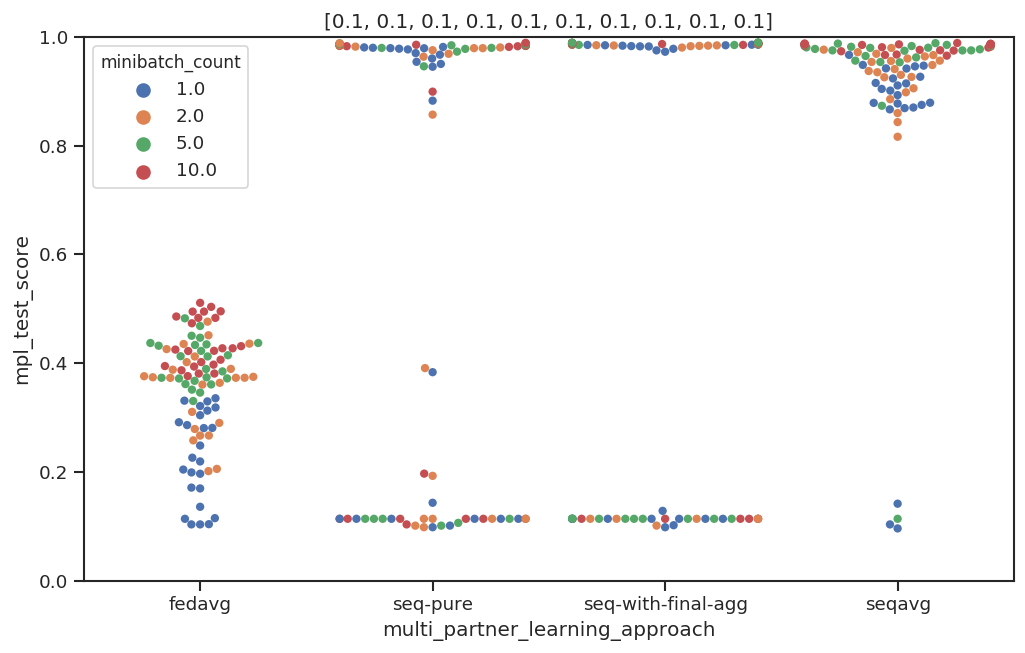

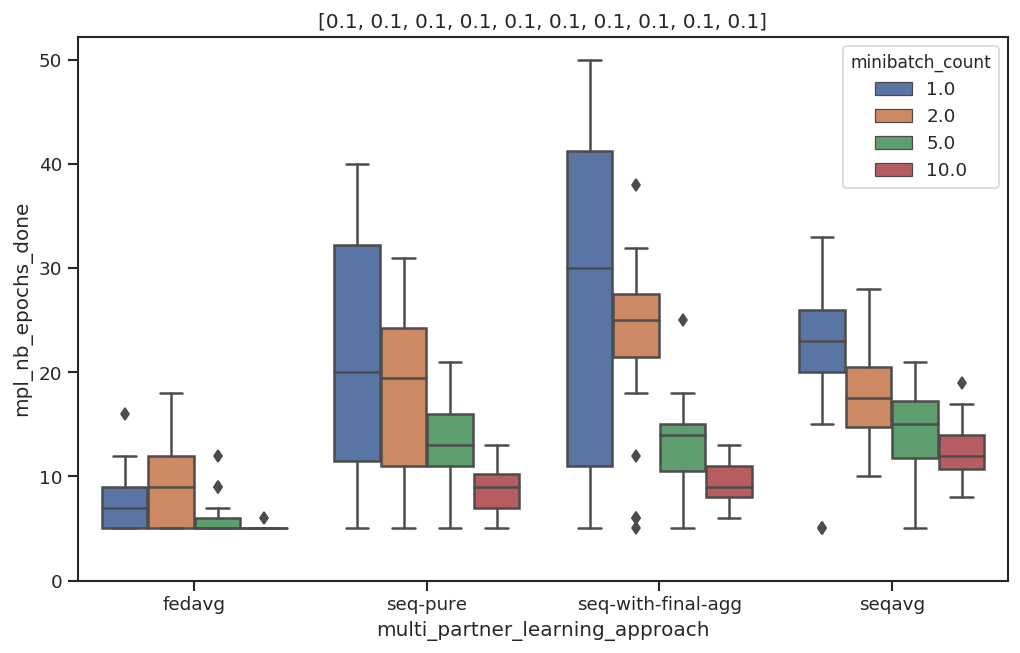

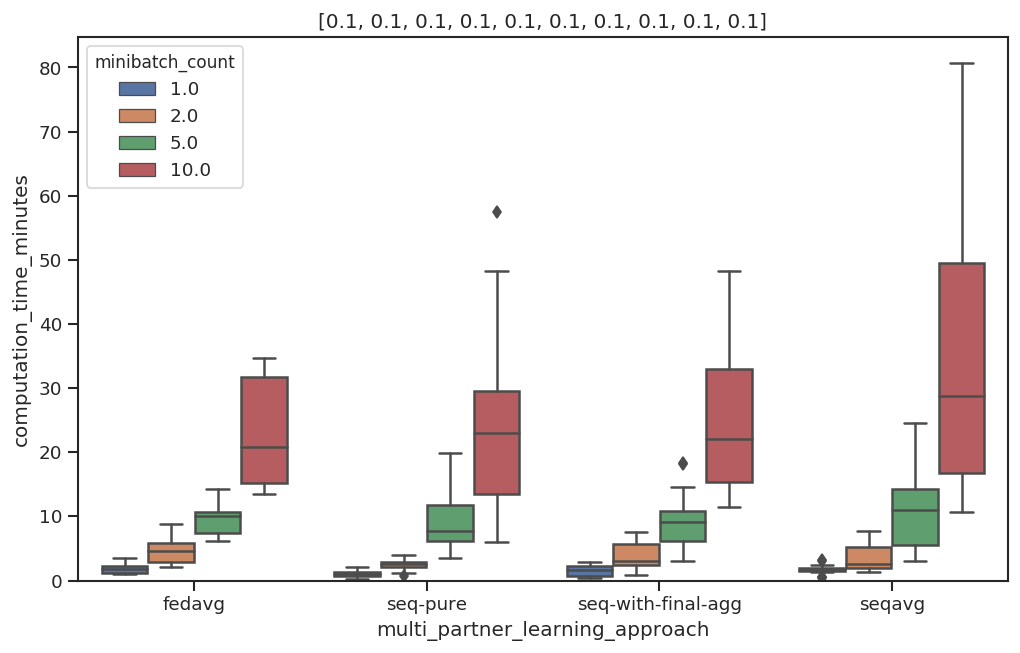

In [50]:
# Plot loop
for amounts_per_partner in amounts_per_partner_list:
    
    current_df = df[df.amounts_per_partner == amounts_per_partner]

    sns.set(style="ticks")
    #current_df.info()
    print("################################################")
    print(amounts_per_partner)

    plt.figure(figsize=(10, 6), dpi=120)
    plt.title(amounts_per_partner)
    ax = sns.swarmplot(x="multi_partner_learning_approach", y="mpl_test_score", hue="minibatch_count",
                       data=current_df)
    plt.ylim([0, 1])

        
    ax = plt.figure(figsize=(10, 6), dpi=120)
    plt.title(amounts_per_partner)
    sns.boxplot(x="multi_partner_learning_approach", y="mpl_nb_epochs_done", hue="minibatch_count",
                     data=current_df)
    plt.ylim(bottom=0)
    
    ax = plt.figure(figsize=(10, 6), dpi=120)
    plt.title(amounts_per_partner)
    sns.boxplot(x="multi_partner_learning_approach", y="computation_time_minutes", hue="minibatch_count",
                     data=current_df)
    plt.ylim(bottom=0)

    
    plt.show()
    

## Losses

In [51]:
df_seq = df[(df.multi_partner_learning_approach == "seq-pure") & (df.minibatch_count == 1)]
df_seq.head(20)


,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
12,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,79.024008,1.0,35.0,...,10.0,stratified,scenario_13_repeat_1_2020-06-08_17h13_f3a,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,12,1.317067
16,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,18.225566,1.0,6.0,...,10.0,stratified,scenario_17_repeat_1_2020-06-08_17h37_a46,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,16,0.303759
20,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,74.163957,1.0,16.0,...,10.0,stratified,scenario_21_repeat_1_2020-06-08_18h15_699,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,20,1.236066
60,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,73.320776,1.0,33.0,...,10.0,stratified,scenario_13_repeat_2_2020-06-09_01h10_c00,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,12,1.222013
64,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,42.618776,1.0,15.0,...,10.0,stratified,scenario_17_repeat_2_2020-06-09_01h27_044,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,16,0.710313
68,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,23.475434,1.0,5.0,...,10.0,stratified,scenario_21_repeat_2_2020-06-09_02h10_267,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,20,0.391257
108,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,47.102421,1.0,21.0,...,10.0,stratified,scenario_13_repeat_3_2020-06-09_09h27_806,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,12,0.785040
112,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,54.241536,1.0,19.0,...,10.0,stratified,scenario_17_repeat_3_2020-06-09_09h49_738,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,16,0.904026
116,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,124.976470,1.0,27.0,...,10.0,stratified,scenario_21_repeat_3_2020-06-09_10h16_5ec,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,20,2.082941
156,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,77.922707,1.0,35.0,...,10.0,stratified,scenario_13_repeat_4_2020-06-09_17h27_163,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,3,12,1.298712


In [52]:
pd.set_option('display.max_seq_items', 40)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', None)


len(df_seq.scenario_name.unique())
df_seq

,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
12,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,79.024008,1.0,35.0,...,10.0,stratified,scenario_13_repeat_1_2020-06-08_17h13_f3a,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,12,1.317067
16,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,18.225566,1.0,6.0,...,10.0,stratified,scenario_17_repeat_1_2020-06-08_17h37_a46,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,16,0.303759
20,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,74.163957,1.0,16.0,...,10.0,stratified,scenario_21_repeat_1_2020-06-08_18h15_699,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,0,20,1.236066
60,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,73.320776,1.0,33.0,...,10.0,stratified,scenario_13_repeat_2_2020-06-09_01h10_c00,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,12,1.222013
64,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,42.618776,1.0,15.0,...,10.0,stratified,scenario_17_repeat_2_2020-06-09_01h27_044,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,16,0.710313
68,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,23.475434,1.0,5.0,...,10.0,stratified,scenario_21_repeat_2_2020-06-09_02h10_267,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,1,20,0.391257
108,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,47.102421,1.0,21.0,...,10.0,stratified,scenario_13_repeat_3_2020-06-09_09h27_806,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,12,0.785040
112,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",8.0,1.0,54.241536,1.0,19.0,...,10.0,stratified,scenario_17_repeat_3_2020-06-09_09h49_738,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,16,0.904026
116,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",16.0,1.0,124.976470,1.0,27.0,...,10.0,stratified,scenario_21_repeat_3_2020-06-09_10h16_5ec,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,2,20,2.082941
156,uniform,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",MNIST,50.0,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.099...",4.0,1.0,77.922707,1.0,35.0,...,10.0,stratified,scenario_13_repeat_4_2020-06-09_17h27_163,"stratified[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",global,10000.0,48000.0,3,12,1.298712


In [53]:
scenario_name = df_seq.scenario_name.iloc[0]
scenario_path = experiment_path / scenario_name
history_data_path = scenario_path / "history_data.p"

In [54]:
with open(history_data_path, 'rb') as f:
    loss_data = pickle.load(f)

In [55]:
loss_data.keys()

dict_keys(['loss_collective_models', 'score_matrix_per_partner', 'score_matrix_collective_models'])

In [56]:
score_matrix_per_partner = loss_data["score_matrix_per_partner"]
score_matrix_per_partner.shape

(50, 1, 10)

Text(0, 0.5, 'Local validation score')

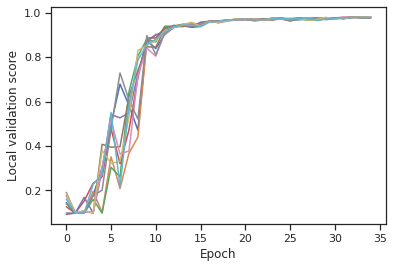

In [57]:
score_matrix_per_partner[score_matrix_per_partner == 0] = 'nan'

partner_idx = 0
plt.plot(score_matrix_per_partner[:, 0, :])
plt.xlabel("Epoch")
plt.ylabel("Local validation score")

In [ ]:
score_matrix_collective_models = loss_data["score_matrix_collective_models"]
print(score_matrix_collective_models.shape)
score_matrix_collective_models[score_matrix_collective_models == 0] = 'nan' # TODO don't init with zero

plt.plot(score_matrix_collective_models[:, 1])
plt.xlabel("Epoch")
plt.ylabel("Global validation score")


Text(0, 0.5, 'Global loss')

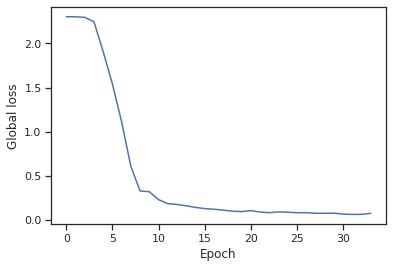

In [58]:
loss_collective_models = loss_data["loss_collective_models"]
loss_collective_models = loss_collective_models[1:] # TODO Why first loss is nan ?
plt.plot(np.arange(len(loss_collective_models)), loss_collective_models)
plt.xlabel("Epoch")
plt.ylabel("Global loss")

scenario_13_repeat_1_2020-06-08_17h13_f3a


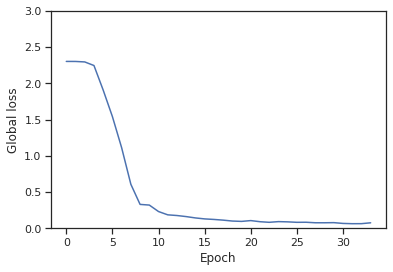

scenario_17_repeat_1_2020-06-08_17h37_a46


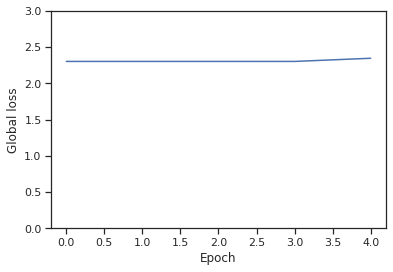

scenario_21_repeat_1_2020-06-08_18h15_699


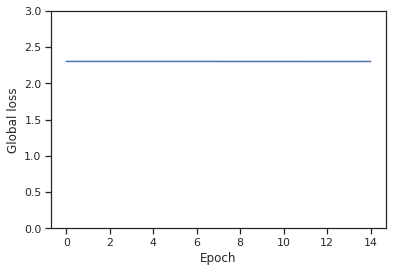

scenario_13_repeat_2_2020-06-09_01h10_c00


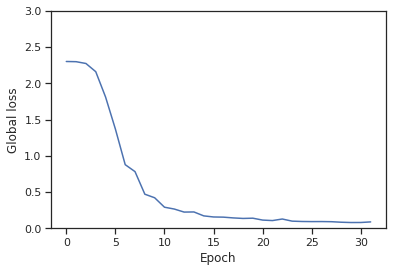

scenario_17_repeat_2_2020-06-09_01h27_044


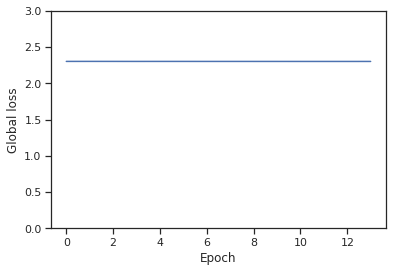

scenario_21_repeat_2_2020-06-09_02h10_267


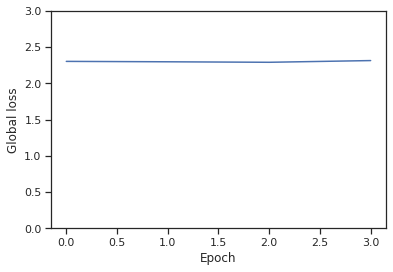

scenario_13_repeat_3_2020-06-09_09h27_806


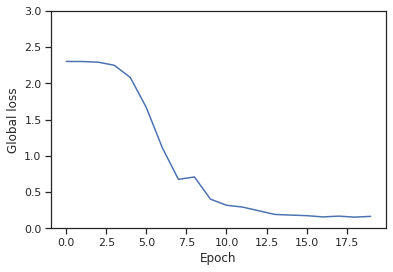

scenario_17_repeat_3_2020-06-09_09h49_738


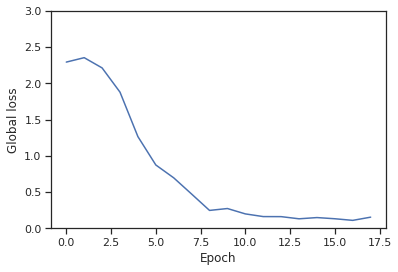

scenario_21_repeat_3_2020-06-09_10h16_5ec


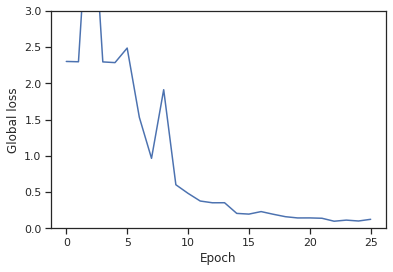

scenario_13_repeat_4_2020-06-09_17h27_163


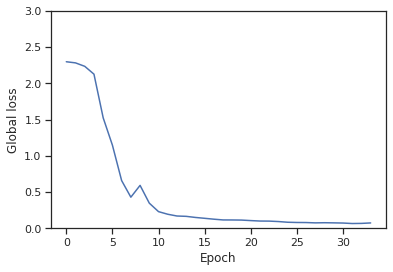

scenario_17_repeat_4_2020-06-09_17h47_f70


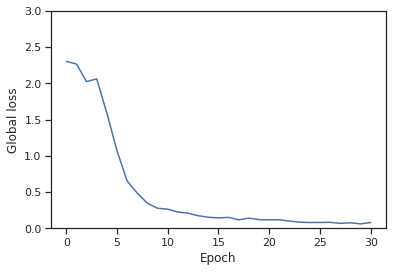

scenario_21_repeat_4_2020-06-09_18h23_970


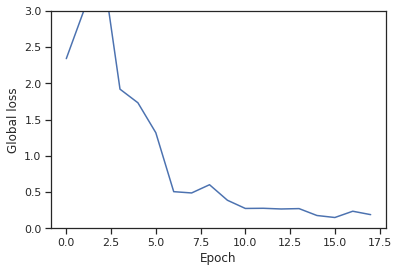

scenario_13_repeat_5_2020-06-10_02h04_ef9


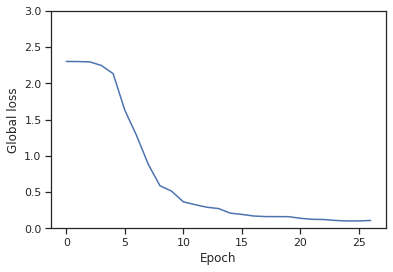

scenario_17_repeat_5_2020-06-10_02h26_ba4


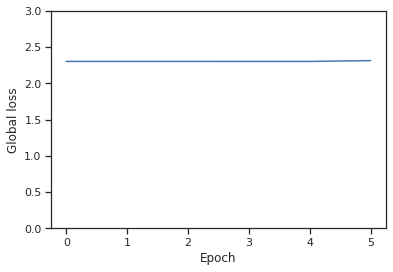

scenario_21_repeat_5_2020-06-10_02h55_d50


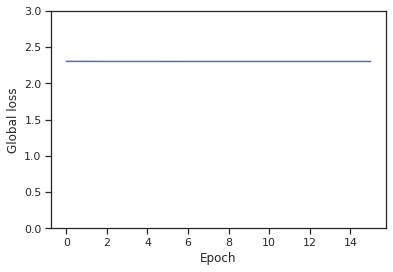

scenario_13_repeat_6_2020-06-10_10h40_9b2


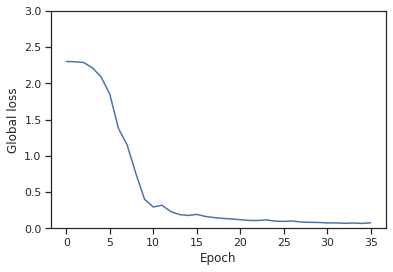

scenario_17_repeat_6_2020-06-10_10h58_8c4


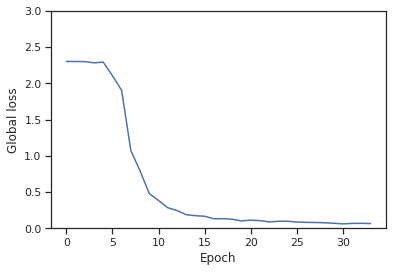

scenario_21_repeat_6_2020-06-10_11h34_6ff


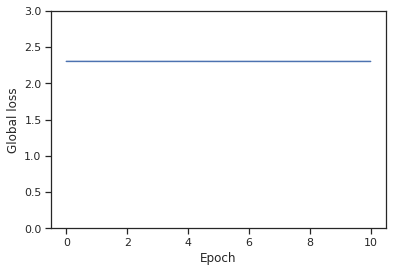

scenario_13_repeat_7_2020-06-10_18h28_95e


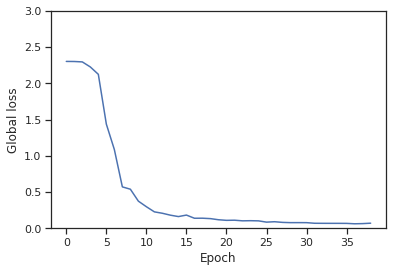

scenario_17_repeat_7_2020-06-10_18h51_8d1


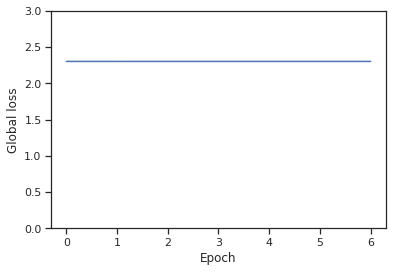

scenario_21_repeat_7_2020-06-10_19h19_5c3


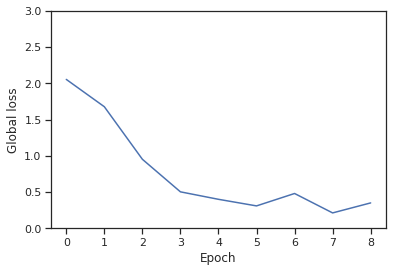

scenario_13_repeat_8_2020-06-11_02h59_e86


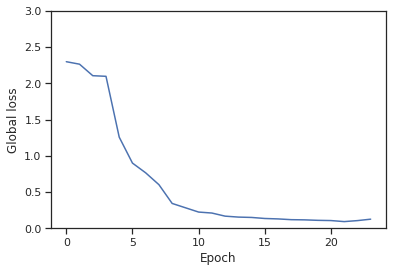

scenario_17_repeat_8_2020-06-11_03h22_f98


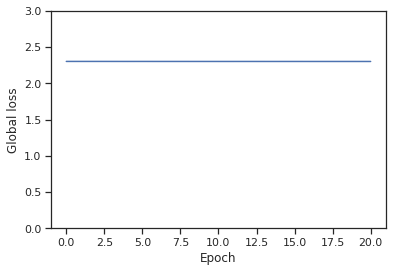

scenario_21_repeat_8_2020-06-11_03h58_05c


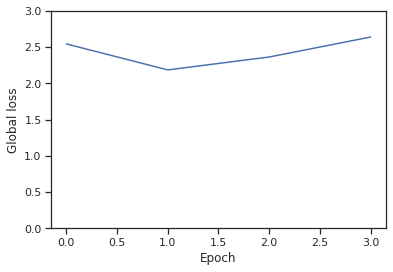

In [62]:

for scenario_name in df_seq.scenario_name:
    print(scenario_name)
    scenario_path = experiment_path / scenario_name
    history_data_path = scenario_path / "history_data.p"
    with open(history_data_path, 'rb') as f:
        loss_data = pickle.load(f)

    loss_collective_models = loss_data["loss_collective_models"]
    loss_collective_models = loss_collective_models[1:] # TODO Why first loss is nan ?
    plt.plot(np.arange(len(loss_collective_models)), loss_collective_models)
    plt.xlabel("Epoch")
    plt.ylabel("Global loss")
    plt.ylim([0, 3])
    plt.show()